## Neural Network Notebook ##

A first draft of the neural network that will be used for the ECG classification project is described in this notebook.

### Initialization ###

We will train our model  with the help of the TensorFlow framework. If you had not installed TensorFlow yet, you can do it easily with the command pip install --upgrade tensorflow.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import modtester as test

from tensorflow import keras

### Part 1 : importing the data and pre-processing the datas ###

We start by importing our tests data. 

#### Converting to Black and White ####

In order to avoid a cheating model, we convert our images to B&W. 
This has been done in the convect_im2bw.py.

#### Balancing the number of datas ####

For now, we have this data distribution :
F : 803
M : 10506
N : 94635
Q : 8039
S : 2779
V : 7236

To avoid any under or over representation of one category, we will first balance our datas in order to have the same number of each category before testing. 

This has been done in the data_balance.py file. 

# PLEASE RUN DATASBALANCE(803,'locationdirectory','sourcedirectory') #

Found 12000 files belonging to 6 classes.
Using 9600 files for training.
Found 12000 files belonging to 6 classes.
Using 2400 files for validation.


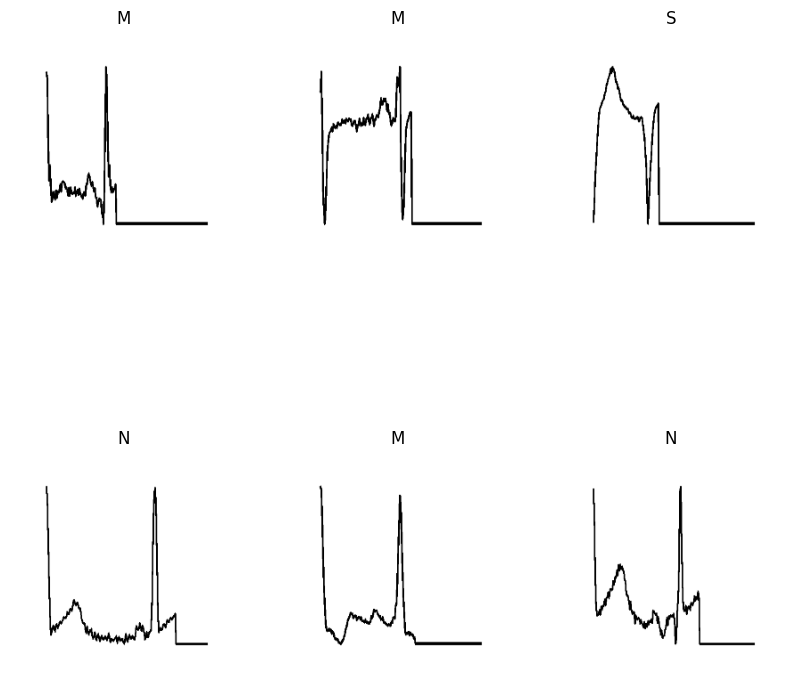

In [11]:
traindata=tf.keras.utils.image_dataset_from_directory(
  #"Full_dataset\ECG_Image_data_cb_bw",
  #"Small_dataset\S_datas_labels_cb_bw",
  "M_dataset\S_datas_labels_bw_bal2000",
  labels='inferred',
  class_names=["F","M","N","Q","S","V"],
  validation_split=0.2,
  subset="training",
  seed=123)

valdata=tf.keras.utils.image_dataset_from_directory(
  #"Full_dataset\ECG_Image_data_cb_bw",
  #"Small_dataset\S_datas_labels_cb_bw",
  "M_dataset\S_datas_labels_bw_bal2000",
  labels='inferred',
  class_names=["F","M","N","Q","S","V"],
  validation_split=0.2,
  subset="validation",
  seed=123)


plt.figure(figsize=(10, 10))
for images, labels in traindata.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(traindata.class_names[labels[i]])
    plt.axis("off")



#### Data standardization ###

For now, RVB channels are in [0,255] which is too large for a neural network. We will then normalize these values. 

NOTE : use only one channel for black and white pictures : search code to convert to black and white.

NOTE 2 :  Rescaling the image can be directly implemented in the model by layer.Rescaling

In [12]:
normalization_layer= tf.keras.layers.Rescaling(1./255)

normtraindata=traindata.map(lambda x, y: (normalization_layer(x),y))

### Part 2 :  creating the model ###

In this part, we define important elements that will be used to build our model. 

NOTE : This model is the one used in the Image Classification tutorial from TensorFlow website, same for the compiler. NEED TO BE RETHINKED AND DISCUSSED. 

PADDING : start with 'Valid' --> 'Same', keep as much information as possible

ACTIVATION function : can be changed also 

FLATTEN : flattening/mapping the pixels

POOLING : change between Max/Average ?

In [13]:
# Model Creation

model= keras.Sequential([
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'), 
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.5), #NEW LAYER to avoid overfitting
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(), #NEW LAYER to avoid overfitting
    keras.layers.Dense(6)
])

model.build((None,256,256,3))

#Model Compiler
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#Model summary 
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)      

### Part 3 : training and testing ###

Note : This code is taken from the TensorFlow tutorial page. 

In [14]:
epochs= 50
history = model.fit(
  normtraindata,
  validation_data=valdata,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

model.save("model/model_bal2000_bw_8_2_50E.h5")

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Epoch 1/20
 25/300 [=>............................] - ETA: 4:28 - loss: 6.8230 - accuracy: 0.2500

KeyboardInterrupt: 

### Part 4 : Testing a random image on the model ###

Very simple code to quickly test some predictions on our model. Has to be improved. 

Found 6 files belonging to 6 classes.
Found 144 files belonging to 6 classes.
Found 6 files belonging to 6 classes.
2/2 [==============================] - 0s 16ms/step
Image 0 || Predicted Disease : Q || True Disease : F
Image 1 || Predicted Disease : Q || True Disease : M
Image 2 || Predicted Disease : Q || True Disease : N
Image 3 || Predicted Disease : Q || True Disease : Q
Image 4 || Predicted Disease : M || True Disease : S
Image 5 || Predicted Disease : Q || True Disease : V
29/29 [==============================] - 1s 47ms/step


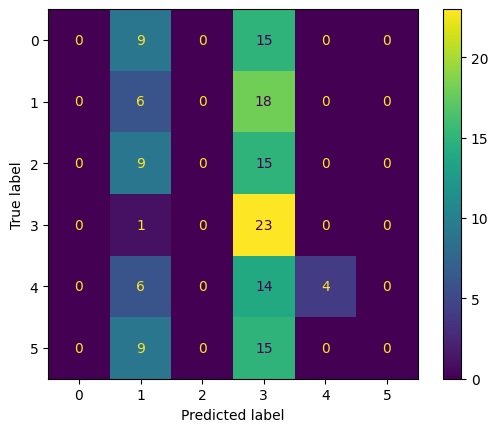

In [ ]:
predata=tf.keras.utils.image_dataset_from_directory("Small_dataset\S_prediction_datas_labels_bw")

test.directmodeltest(model,False)
